In [3]:
import lsdb
lsdb.__version__

'0.6.4'

In [4]:
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import textwrap
from dask.distributed import Client


# diaObject

In [3]:
root = Path("/sdf/scratch/rubin/ppdb/data/lsstcam")

# Recursively gather every *.parquet file
parquet_files = sorted(root.rglob("*.parquet"))

print(f"Found {len(parquet_files):,} parquet files")


root = Path("/sdf/scratch/rubin/ppdb/data/lsstcam")

# Find all DiaObject.parquet files
diaobject_files = sorted(root.rglob("DiaObject.parquet"))
print(f"Found {len(diaobject_files)} DiaObject.parquet files")

diaobject_df_list = []
diasource_df_list = []

for obj_path in tqdm(diaobject_files):
    try:
        # Load DiaObject.parquet
        diaobject_df_list.append(pd.read_parquet(obj_path))
    except Exception as e:
        print(f"Failed to read {obj_path}: {e}")
    
    # Look for DiaSource.parquet in the same directory
    #source_path = obj_path.parent / "DiaSource.parquet"
    #if source_path.exists():
    #    try:
    #        diasource_df_list.append(pd.read_parquet(source_path))
    #    except Exception as e:
    #        print(f"Failed to read {source_path}: {e}")

# Concatenate results
diaobject_df = pd.concat(diaobject_df_list, ignore_index=True) if diaobject_df_list else pd.DataFrame()
#diasource_df = pd.concat(diasource_df_list, ignore_index=True) if diasource_df_list else pd.DataFrame()

print(f"DiaObject DataFrame shape: {diaobject_df.shape}")
#print(f"DiaSource DataFrame shape: {diasource_df.shape}")

# Now you can work with diaobject_df and diasource_df


Found 440 parquet files
Found 175 DiaObject.parquet files


100%|██████████| 175/175 [01:16<00:00,  2.29it/s]


DiaObject DataFrame shape: (43304705, 190)


In [9]:
import numpy as np
diaObjectId, count_diaObjectId = np.unique(diaobject_df['diaObjectId'],return_counts=True)

In [ ]:
test_df = diaobject_df[diaobject_df['diaObjectId'] == diaObjectId[1]]

In [16]:
latest_df = test_df.sort_values('validityStart').groupby('diaObjectId', as_index=False).tail(1)
latest_df

,diaObjectId,validityStart,dec,decErr,g_fpFluxMean,g_fpFluxMeanErr,g_fpFluxSigma,g_psfFluxChi2,g_psfFluxErrMean,g_psfFluxLinearIntercept,...,z_psfFluxPercentile25,z_psfFluxPercentile50,z_psfFluxPercentile75,z_psfFluxPercentile95,z_psfFluxSigma,z_psfFluxSkew,z_psfFluxStetsonJ,z_scienceFluxMean,z_scienceFluxMeanErr,z_scienceFluxSigma
1626161,24624703889473541,2025-05-02 04:06:17.513000+00:00,6.569848,0.000046,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Ensure validityStart is datetime with timezone awareness
diaobject_df['validityStart'] = pd.to_datetime(diaobject_df['validityStart'], utc=True)

# Sort by diaObjectId and validityStart, then keep the last (latest) row per diaObjectId
latest_per_object = (
    diaobject_df
    .sort_values(['diaObjectId', 'validityStart'])
    .groupby('diaObjectId', as_index=False)
    .tail(1)
)

In [19]:
len(diaobject_df)

43304705

In [20]:
len(diaobject_df)/ len(latest_per_object)

4.640771510344849

In [21]:
test_id = np.unique(latest_per_object['diaObjectId'],return_counts=True)

In [23]:
diaobject_df_singleid = latest_per_object

In [24]:
diaobject_cat_test = lsdb.from_dataframe(diaobject_df_singleid, highest_order=10)   
diaobject_cat_test.to_hats("/sdf/data/rubin/shared/lsdb_commissioning/hats/PPDB/diaobject_cat_test", overwrite=True)

/sdf/home/n/ncaplar/.local/lib/python3.12/site-packages/lsdb/loaders/dataframe/dataframe_catalog_loader.py:136: RuntimeWarning: from_dataframe is not intended for large datasets. Consider using hats-import: https://hats-import.readthedocs.io/
  warnings.warn(
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(10), input_type=int64])
  return self.__pydantic_serializer__.to_python(


In [25]:
pd.set_option('display.max_columns', 20)  # Show all columns

# diaSource

In [ ]:
client = Client(n_workers=1, memory_limit="400GiB", threads_per_worker=1)
# Print the dashboard link and port
print(f"Dask is running at: {client.dashboard_link}")

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/scheduler-tpol1hz9', purging
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/worker-qh3szik1', purging
INFO:distributed.scheduler:  Scheduler at:      tcp://127.0.0.1:9223
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:11723'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:24909 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:24909
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:30190
INFO:distributed.scheduler:Receive clien

Dask is running at: http://127.0.0.1:8787/status


INFO:distributed.nanny:Closing Nanny gracefully at 'tcp://127.0.0.1:11723'. Reason: worker-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:30190; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:24909 name: 0 (stimulus_id='handle-worker-cleanup-1754417837.8887842')
INFO:distributed.scheduler:Lost all workers
INFO:distributed.nanny:Worker process 3566049 exited with status 1
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:11723'. Reason: nanny-close-gracefully
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:11723' closed.
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-2061334' coro=<Client._gather.<locals>.wait() done, defined at /sdf/home/n/ncaplar/.local/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/sdf/home/n/ncaplar/.local/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
di

In [6]:
root = Path("/sdf/scratch/rubin/ppdb/data/lsstcam")

# Recursively gather every *.parquet file
parquet_files = sorted(root.rglob("*.parquet"))

print(f"Found {len(parquet_files):,} parquet files")


root = Path("/sdf/scratch/rubin/ppdb/data/lsstcam")

# Find all DiaObject.parquet files
diasource_files = sorted(root.rglob("DiaSource.parquet"))
print(f"Found {len(diasource_files)} DiaSource.parquet files")

diaobject_df_list = []
diasource_df_list = []
"""
for obj_path in tqdm(diaobject_files):
    #try:
    #    # Load DiaObject.parquet
    #    diaobject_df_list.append(pd.read_parquet(obj_path))
    #except Exception as e:
    #    print(f"Failed to read {obj_path}: {e}")
    #
    # Look for DiaSource.parquet in the same directory
    source_path = obj_path.parent / "DiaSource.parquet"
    if source_path.exists():
        try:
            diasource_df_list.append(pd.read_parquet(source_path))
        except Exception as e:
            print(f"Failed to read {source_path}: {e}")

# Concatenate results
#diaobject_df = pd.concat(diaobject_df_list, ignore_index=True) if diaobject_df_list else pd.DataFrame()
diasource_df = pd.concat(diasource_df_list, ignore_index=True) if diasource_df_list else pd.DataFrame()

#print(f"DiaSource DataFrame shape: {diasource_df.shape}")

# Now you can work with diaobject_df and diasource_df
"""


Found 440 parquet files
Found 175 DiaSource.parquet files


'\nfor obj_path in tqdm(diaobject_files):\n    #try:\n    #    # Load DiaObject.parquet\n    #    diaobject_df_list.append(pd.read_parquet(obj_path))\n    #except Exception as e:\n    #    print(f"Failed to read {obj_path}: {e}")\n    #\n    # Look for DiaSource.parquet in the same directory\n    source_path = obj_path.parent / "DiaSource.parquet"\n    if source_path.exists():\n        try:\n            diasource_df_list.append(pd.read_parquet(source_path))\n        except Exception as e:\n            print(f"Failed to read {source_path}: {e}")\n\n# Concatenate results\n#diaobject_df = pd.concat(diaobject_df_list, ignore_index=True) if diaobject_df_list else pd.DataFrame()\ndiasource_df = pd.concat(diasource_df_list, ignore_index=True) if diasource_df_list else pd.DataFrame()\n\n#print(f"DiaSource DataFrame shape: {diasource_df.shape}")\n\n# Now you can work with diaobject_df and diasource_df\n'

In [10]:
import hats_import.pipeline as runner
from hats_import.catalog.arguments import ImportArguments
from hats_import.catalog.file_readers import ParquetReader
import pyarrow.parquet as pq
import pyarrow as pa

args = ImportArguments(
    output_artifact_name="diasource_cat_test",
    input_file_list=diasource_files,
    file_reader="parquet",
    catalog_type="source",
    sort_columns="diaObjectId",
    highest_healpix_order=10,
    output_path="/sdf/data/rubin/shared/lsdb_commissioning/hats/PPDB/",
)

In [11]:
runner.pipeline(args)

/sdf/home/n/ncaplar/.local/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 19711 instead
  warnings.warn(
INFO:distributed.scheduler:State start


INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:18043
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:19711/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:21751'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:13037 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:13037
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:26528
INFO:distributed.scheduler:Receive client connection: Client-6e440ae8-722a-11f0-9095-7c8c09b08b0c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:26534


Planning  :   0%|          | 0/4 [00:00<?, ?it/s]

Mapping   :   0%|          | 0/175 [00:00<?, ?it/s]

Binning   :   0%|          | 0/2 [00:00<?, ?it/s]

Splitting :   0%|          | 0/175 [00:00<?, ?it/s]

Reducing  :   0%|          | 0/96 [00:00<?, ?it/s]

Finishing :   0%|          | 0/5 [00:00<?, ?it/s]

INFO:distributed.scheduler:Remove client Client-6e440ae8-722a-11f0-9095-7c8c09b08b0c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:26534; closing.
INFO:distributed.scheduler:Remove client Client-6e440ae8-722a-11f0-9095-7c8c09b08b0c
INFO:distributed.scheduler:Close client connection: Client-6e440ae8-722a-11f0-9095-7c8c09b08b0c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1754420512.4021227') (0,)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:21751'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:26528; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:13037 name: 0 (stimulus_id='handle-worker-cleanup-1754420512.4063268')
INFO:distributed.scheduler:Lost all workers
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:21751' closed.
INFO:distributed.scheduler:Closing scheduler. Reason: unknown


In [ ]:
# Format columns so each line is at most 120 chars
# col_str = ", ".join(diasource_df.columns)
# wrapped_cols = "\n".join(textwrap.wrap(col_str, width=180))
# print("DiaSource columns:\n", wrapped_cols)

DiaSource columns:
 diaSourceId, apFlux, apFluxErr, apFlux_flag, apFlux_flag_apertureTruncated, band, bboxSize, centroid_flag, dec, decErr, detector, diaObjectId, dipoleAngle, dipoleAngleErr,
dipoleChi2, dipoleDec, dipoleDecErr, dipoleDec_dipoleAngle_Cov, dipoleDec_dipoleLength_Cov, dipoleFitAttempted, dipoleFluxDiff, dipoleFluxDiffErr, dipoleFluxDiff_dipoleAngle_Cov,
dipoleFluxDiff_dipoleDec_Cov, dipoleFluxDiff_dipoleLength_Cov, dipoleFluxDiff_dipoleRa_Cov, dipoleLength, dipoleLengthErr, dipoleLength_dipoleAngle_Cov, dipoleLnL, dipoleMeanFlux,
dipoleMeanFluxErr, dipoleMeanFlux_dipoleAngle_Cov, dipoleMeanFlux_dipoleDec_Cov, dipoleMeanFlux_dipoleFluxDiff_Cov, dipoleMeanFlux_dipoleLength_Cov, dipoleMeanFlux_dipoleRa_Cov,
dipoleNdata, dipoleRa, dipoleRaErr, dipoleRa_dipoleAngle_Cov, dipoleRa_dipoleDec_Cov, dipoleRa_dipoleLength_Cov, extendedness, forced_PsfFlux_flag, forced_PsfFlux_flag_edge,
forced_PsfFlux_flag_noGoodPixels, fpBkgd, fpBkgdErr, isDipole, is_negative, ixx, ixxErr, ixxPSF, 

# Nesting

In [5]:
client = Client(n_workers=3, memory_limit="180GiB", threads_per_worker=2)
# Print the dashboard link and port
print(f"Dask is running at: {client.dashboard_link}")

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
/sdf/home/n/ncaplar/.local/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32281 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:12667
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:32281/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:2747'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:12915'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:16245'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:19689 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:19689
INFO

Dask is running at: http://127.0.0.1:32281/status


In [7]:
hats_dir = Path("/sdf/data/rubin/shared/lsdb_commissioning/hats/PPDB")
dia_object_cat = lsdb.read_hats(hats_dir / "diaobject_cat_test")
dia_source_cat = lsdb.read_hats(hats_dir / "diasource_cat_test")

In [8]:
dia_object_cat_nested = dia_object_cat.join_nested(
    dia_source_cat,
    left_on="diaObjectId",
    right_on="diaObjectId",
    nested_column_name="diaSource",
)
dia_object_cat_nested

/sdf/home/n/ncaplar/.local/lib/python3.12/site-packages/lsdb/dask/join_catalog_data.py:335: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,diaObjectId,validityStart,dec,decErr,g_fpFluxMean,g_fpFluxMeanErr,g_fpFluxSigma,g_psfFluxChi2,g_psfFluxErrMean,g_psfFluxLinearIntercept,g_psfFluxLinearSlope,g_psfFluxMAD,g_psfFluxMax,g_psfFluxMaxSlope,g_psfFluxMean,g_psfFluxMeanErr,g_psfFluxMin,g_psfFluxNdata,g_psfFluxPercentile05,g_psfFluxPercentile25,g_psfFluxPercentile50,g_psfFluxPercentile75,g_psfFluxPercentile95,g_psfFluxSigma,g_psfFluxSkew,g_psfFluxStetsonJ,g_scienceFluxMean,g_scienceFluxMeanErr,g_scienceFluxSigma,i_fpFluxMean,i_fpFluxMeanErr,i_fpFluxSigma,i_psfFluxChi2,i_psfFluxErrMean,i_psfFluxLinearIntercept,i_psfFluxLinearSlope,i_psfFluxMAD,i_psfFluxMax,i_psfFluxMaxSlope,i_psfFluxMean,i_psfFluxMeanErr,i_psfFluxMin,i_psfFluxNdata,i_psfFluxPercentile05,i_psfFluxPercentile25,i_psfFluxPercentile50,i_psfFluxPercentile75,i_psfFluxPercentile95,i_psfFluxSigma,i_psfFluxSkew,i_psfFluxStetsonJ,i_scienceFluxMean,i_scienceFluxMeanErr,i_scienceFluxSigma,lastNonForcedSource,nDiaSources,nearbyExtObj1,nearbyExtObj1Sep,nearbyExtObj2,nearbyExtObj2Sep,nearbyExtObj3,nearbyExtObj3Sep,nearbyLowzGal,nearbyLowzGalSep,nearbyObj1,nearbyObj1Dist,nearbyObj1LnP,nearbyObj2,nearbyObj2Dist,nearbyObj2LnP,nearbyObj3,nearbyObj3Dist,nearbyObj3LnP,parallax,parallaxErr,pmDec,pmDecErr,pmDec_parallax_Cov,pmParallaxChi2,pmParallaxLnL,pmParallaxNdata,pmRa,pmRaErr,pmRa_parallax_Cov,pmRa_pmDec_Cov,r_fpFluxMean,r_fpFluxMeanErr,r_fpFluxSigma,r_psfFluxChi2,r_psfFluxErrMean,r_psfFluxLinearIntercept,r_psfFluxLinearSlope,r_psfFluxMAD,r_psfFluxMax,r_psfFluxMaxSlope,r_psfFluxMean,r_psfFluxMeanErr,r_psfFluxMin,r_psfFluxNdata,r_psfFluxPercentile05,r_psfFluxPercentile25,r_psfFluxPercentile50,r_psfFluxPercentile75,r_psfFluxPercentile95,r_psfFluxSigma,r_psfFluxSkew,r_psfFluxStetsonJ,r_scienceFluxMean,r_scienceFluxMeanErr,r_scienceFluxSigma,ra,raErr,ra_dec_Cov,radecMjdTai,u_fpFluxMean,u_fpFluxMeanErr,u_fpFluxSigma,u_psfFluxChi2,u_psfFluxErrMean,u_psfFluxLinearIntercept,u_psfFluxLinearSlope,u_psfFluxMAD,u_psfFluxMax,u_psfFluxMaxSlope,u_psfFluxMean,u_psfFluxMeanErr,u_psfFluxMin,u_psfFluxNdata,u_psfFluxPercentile05,u_psfFluxPercentile25,u_psfFluxPercentile50,u_psfFluxPercentile75,u_psfFluxPercentile95,u_psfFluxSigma,u_psfFluxSkew,u_psfFluxStetsonJ,u_scienceFluxMean,u_scienceFluxMeanErr,u_scienceFluxSigma,validityEnd,y_fpFluxMean,y_fpFluxMeanErr,y_fpFluxSigma,y_psfFluxChi2,y_psfFluxErrMean,y_psfFluxLinearIntercept,y_psfFluxLinearSlope,y_psfFluxMAD,y_psfFluxMax,y_psfFluxMaxSlope,y_psfFluxMean,y_psfFluxMeanErr,y_psfFluxMin,y_psfFluxNdata,y_psfFluxPercentile05,y_psfFluxPercentile25,y_psfFluxPercentile50,y_psfFluxPercentile75,y_psfFluxPercentile95,y_psfFluxSigma,y_psfFluxSkew,y_psfFluxStetsonJ,y_scienceFluxMean,y_scienceFluxMeanErr,y_scienceFluxSigma,z_fpFluxMean,z_fpFluxMeanErr,z_fpFluxSigma,z_psfFluxChi2,z_psfFluxErrMean,z_psfFluxLinearIntercept,z_psfFluxLinearSlope,z_psfFluxMAD,z_psfFluxMax,z_psfFluxMaxSlope,z_psfFluxMean,z_psfFluxMeanErr,z_psfFluxMin,z_psfFluxNdata,z_psfFluxPercentile05,z_psfFluxPercentile25,z_psfFluxPercentile50,z_psfFluxPercentile75,z_psfFluxPercentile95,z_psfFluxSigma,z_psfFluxSkew,z_psfFluxStetsonJ,z_scienceFluxMean,z_scienceFluxMeanErr,z_scienceFluxSigma,diaSource
npartitions=96,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 2, Pixel: 102",int64[pyarrow],"timestamp[ms, tz=UTC][pyarrow]",double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int32[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double

(<Figure size 900x500 with 1 Axes>,
 <WCSAxes: title={'center': 'Coverage MOC of from_lsdb_dataframe'}>)

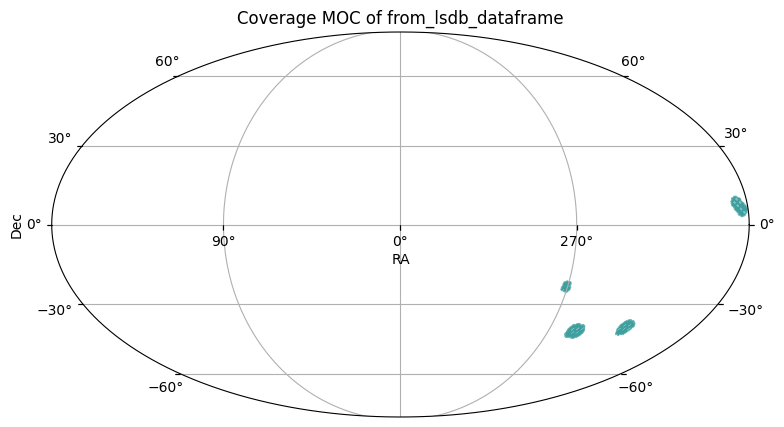

In [10]:
dia_object_cat_nested.plot_coverage()

In [11]:
dia_object_cat_nested

dia_object_cat_nested.to_hats(hats_dir / "dia_object_lc", catalog_name="dia_object_lc", overwrite=True)


In [12]:
dia_object_cat_nested.head(5)

diaObjectId                     validityStart  \
_healpix_29                                                                
1850960884083008805  24624703953960961  2025-05-02 01:24:08.373000+00:00   
1850961073758726246  24624703953960963  2025-05-02 01:24:08.373000+00:00   
1850961074769530631  24624703953960964  2025-05-02 01:24:08.373000+00:00   
1850960888499710711  24624703953960968  2025-05-02 01:24:08.373000+00:00   
1850961236462484413  24624703953960975  2025-05-02 01:24:08.373000+00:00   

                          dec    decErr  g_fpFluxMean  g_fpFluxMeanErr  \
_healpix_29                                                              
1850960884083008805  4.374248      <NA>          <NA>             <NA>   
1850961073758726246  4.385591  0.000038          <NA>             <NA>   
1850961074769530631  4.387335  0.000034          <NA>             <NA>   
1850960888499710711  4.379227  0.000222          <NA>             <NA>   
1850961236462484413  4.407465  0.000016          <NA>             <NA>   

                     g_fpFluxSigma  g_psfFluxChi2  g_psfFluxErrMean  \
_healpix_29                                                           
1850960884083008805           <NA>           <NA>              <NA>   
1850961073758726246           <NA>           <NA>              <NA>   
1850961074769530631           <NA>           <NA>              <NA>   
1850960888499710711           <NA>           <NA>              <NA>   
1850961236462484413           <NA>           <NA>              <NA>   

                     g_psfFluxLinearIntercept  ...  z_psfFluxPercentile50  \
_healpix_29                                    ...                          
1850960884083008805                      <NA>  ...                   <NA>   
1850961073758726246                      <NA>  ...                   <NA>   
1850961074769530631                      <NA>  ...                   <NA>   
1850960888499710711                      <NA>  ...                   <NA>   
1850961236462484413                      <NA>  ...                   <NA>   

                     z_psfFluxPercentile75  z_psfFluxPercentile95  \
_healpix_29                                                         
1850960884083008805                   <NA>                   <NA>   
1850961073758726246                   <NA>                   <NA>   
1850961074769530631                   <NA>                   <NA>   
1850960888499710711                   <NA>                   <NA>   
1850961236462484413                   <NA>                   <NA>   

                     z_psfFluxSigma  z_psfFluxSkew  z_psfFluxStetsonJ  \
_healpix_29                                                             
1850960884083008805            <NA>           <NA>               <NA>   
1850961073758726246            <NA>           <NA>               <NA>   
1850961074769530631            <NA>           <NA>               <NA>   
1850960888499710711            <NA>           <NA>               <NA>   
1850961236462484413            <NA>           <NA>               <NA>   

                     z_scienceFluxMean  z_scienceFluxMeanErr  \
_healpix_29                                                    
1850960884083008805               <NA>                  <NA>   
1850961073758726246               <NA>                  <NA>   
1850961074769530631               <NA>                  <NA>   
1850960888499710711               <NA>                  <NA>   
1850961236462484413               <NA>                  <NA>   

                     z_scienceFluxSigma  \
_healpix_29                               
1850960884083008805                <NA>   
1850961073758726246                <NA>   
1850961074769530631                <NA>   
1850960888499710711                <NA>   
1850961236462484413                <NA>   

                                                             diaSource  
_healpix_29                                                             
1850960884083008805  [{diaSourceId: 24624703